# Multiclass classification on MNIST dataset
The main goal of this project is to compare results of multiclass classification on MNIST data set using two well-known Python packages: Scikit-Learn and TensorFlow, hence these two libraries are required.
## MNIST dataset
MNIST is database of handwritten digits commonly used for classifiers testing (i.e image processing systems). We can load this dataset from *sklearn.datasets* package. Let's do it and check its structure.

In [4]:
from sklearn.datasets import fetch_mldata

#Fetch data
mnist = fetch_mldata('MNIST original')
X = mnist['data']
y = mnist['target']

mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

Now we want to see what the collection represents. Let's look at a random sample and visualize it using Matplotlib module. 

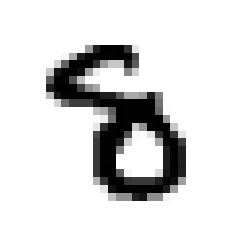

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

sample = X[50000]
sample_image = sample.reshape(28,28)

plt.imshow(sample_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

Currently, we would like to see a few examples from each class (there are ten classes, as many as numbers). The following code implements this possibility (ten examples for each digit)

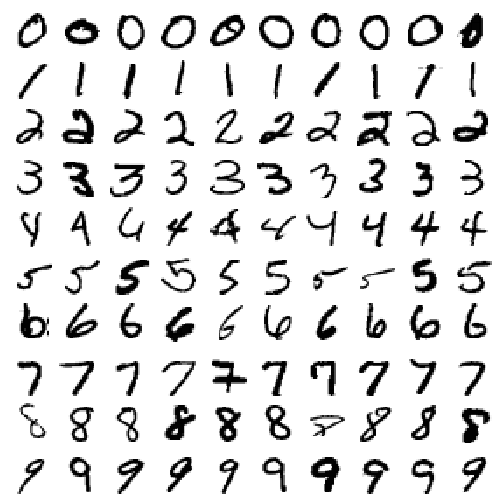

In [6]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")
    
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

## Learning classifier system
Now that we know what the data set looks like, on which we operate, we can train the system. In the first place, we will use the classes available in the Sciki-Learn package. The MNIST collection was divided in advance into a training and test set, so the only thing left for us is to mix the training set to get a uniform class distribution. Note note that this operation is not necessary in relation to the set on which we will test the classifier's performance.

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y[shuffle_index]

Then we perform a simple preprocessing (feature scaling). 

In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
X_test_scaled = scaler.fit_transform(X_test.astype(np.float64))

### Stochastic Gradient Descent
Now we are ready to train the model. At first we apply classifier learned by stochastic gradient descent as it is very simple and works well in the first approach.

In [12]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train_scaled,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Now, since the model is already trained, let's do a cross-validation and visualize its performance using confusion matrix - rows represent labels and columns represent predicted outputs. The lighter the shade of white of the block, the higher value is at the intersection of a given row and column (we want the diagonal blocks to be bright and the black ones to be dark)  

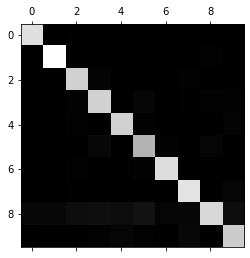

In [14]:
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train_pred, y_train)
plt.matshow(conf_mx, cmap=plt.cm.gray)

In general, you can say that the classifier performs well (all off-diagonal blocks are black and the result of cross-validation test are at a similarly high level). To focus on the errors, we will black out the diagonal blocks and normalize the confusion matrix relative to the columns. Below it is illustrated in graphic form. 

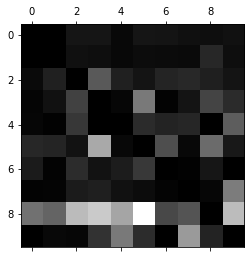

In [15]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

We see that this matrix is not symmetric and the eighth row is extremely bright, which means that many examples have been incorrectly classified as the digit eight. Below are presented numerical data for accuracy measures appropriate for classifiers. Also the bar graph for the F1 measure has been ilustrated.

Precision scores:  [0.96122449 0.96211454 0.87596899 0.87326733 0.901222   0.8206278
 0.91649269 0.90758755 0.91889117 0.85827552]
Recall scores:  [0.96122449 0.98201439 0.93581781 0.92259414 0.93849417 0.89159562
 0.94307197 0.94528875 0.65954311 0.91446674]
F1 scores:  [0.96122449 0.97196262 0.9049049  0.89725331 0.91948052 0.85464098
 0.92959238 0.92605459 0.76791077 0.88548057]


<BarContainer object of 10 artists>

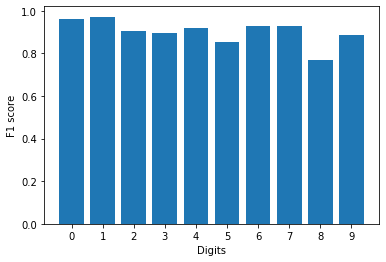

In [44]:
from sklearn.metrics import precision_score ,recall_score, f1_score 

y_test_pred = sgd_clf.predict(X_test_scaled)
print("Precision scores: ", precision_score(y_test_pred,y_test,average=None))
print("Recall scores: ", recall_score(y_test_pred,y_test,average=None))
print("F1 scores: ", f1_score(y_test_pred,y_test,average=None))

plt.xticks((0, 1, 2, 3, 4, 5, 6, 7, 8, 9))
plt.xlabel('Digits')
plt.ylabel('F1 score')
plt.bar((0, 1, 2, 3, 4, 5, 6, 7, 8, 9),f1_score(y_test_pred,y_test,average=None)) 

As it resulted from a confusion matrix, our system is worst in recognizing the number 8 (incorrectly classifies many examples as digit 8). Let's focus now on another learning algorithm offered by the Scikit-Learn package: a random forest algorithm.
### Random Forest Classifier
This algorithm is more complicated and usually results in better training of the classifier.

In [45]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train_scaled,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Let's look at the results, as in the case of the Stochastic Gradient Descent classifier.

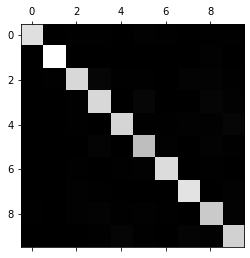

In [47]:
y_train_pred = cross_val_predict(forest_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train_pred, y_train)
plt.matshow(conf_mx, cmap=plt.cm.gray)

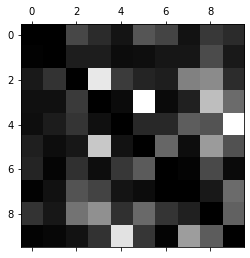

In [48]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

In this case, the classifier often confuses the numbers 3 and 5 (classifies 5 as 3 and vice versa). However, this is understandable when we look at badly categorized examples.

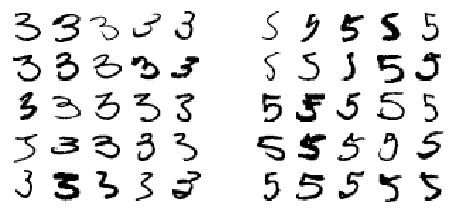

In [55]:
miss_class3 = X_train[(y_train==3) & (y_train_pred==5)]
miss_class5 = X_train[(y_train==5) & (y_train_pred==3)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(miss_class3[:25], images_per_row=5)
plt.subplot(222); plot_digits(miss_class5[:25], images_per_row=5)
plt.show()

Some of these figures actually look misleading. At the end, check the performance on the test set.

Precision scores:  [0.98877551 0.89251101 0.94767442 0.90990099 0.82790224 0.92040359
 0.93736952 0.70817121 0.88193018 0.65411298]
Recall scores:  [0.88899083 0.96752627 0.82323232 0.76455907 0.94644936 0.67795211
 0.94031414 0.99047619 0.85133796 0.9375    ]
F1 scores:  [0.93623188 0.92850596 0.88108108 0.83092224 0.88321564 0.78078935
 0.93883952 0.825865   0.86636409 0.77057793]


<BarContainer object of 10 artists>

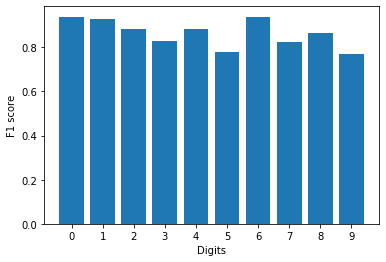

In [56]:
y_test_pred = forest_clf.predict(X_test_scaled)
print("Precision scores: ", precision_score(y_test_pred,y_test,average=None))
print("Recall scores: ", recall_score(y_test_pred,y_test,average=None))
print("F1 scores: ", f1_score(y_test_pred,y_test,average=None))

plt.xticks((0, 1, 2, 3, 4, 5, 6, 7, 8, 9))
plt.xlabel('Digits')
plt.ylabel('F1 score')
plt.bar((0, 1, 2, 3, 4, 5, 6, 7, 8, 9),f1_score(y_test_pred,y_test,average=None)) 